In [1]:
import torch; torch.manual_seed(0)
import torch.distributions
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import pandas as pd
import ipdb
import os, sys, glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import json
from sklearn.manifold import TSNE
import pathlib
from collections import Counter
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("__file__"), '..')))
from models.vanilla_vae import VanillaVAE
from utils import ProgressMeter, AverageMeter, save_checkpoint, TiffDataset

/home/kangzigi/miniconda3/envs/pixel-ai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load best Model

In [2]:
# declaring the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 250
batch_size = 256
lr = 0.001
latent_dims = 8
channels = [0, 1, 2, 25, 27, 29]
in_channels = len(channels)
hidden_dims = [ 16, 32, 64, 128, 256]
best_loss_val = 99999999
kld_weight = 0.000025
input_dimensions = (128, 128)

transform_to_image = T.ToPILImage()
cores_folder = 'TMA_18_810/'
files_path='/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/{0}'.format(cores_folder)
model_path='/data/projects/pixel_project/saved_models'
model_name = "model_best_allcores_randompatches_[0, 1, 2, 25, 27, 29]"

model = VanillaVAE(in_channels=in_channels, latent_dim=latent_dims, input_dimensions=input_dimensions, hidden_dims=hidden_dims).to(device) # GPU
checkpoint = torch.load('{}/{}_vae.pth.tar'.format(model_path, model_name))

for key in list(checkpoint['state_dict'].keys()):
    if 'module.' in key:
        checkpoint['state_dict'][key.replace('module.', '')] = checkpoint['state_dict'][key]
        del checkpoint['state_dict'][key]

model.load_state_dict(checkpoint['state_dict'])
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

## Apply model on dataset and extract Latent space

In [3]:
import random

patches_files = [os.path.join(r, fn)
        for r, ds, fs in os.walk(files_path)
        for fn in fs if fn.endswith('.tiff')]
tiff_dataset = TiffDataset(files=patches_files, 
transform=T.Resize(input_dimensions), 
channels=channels) # random.choices(patches_files, k=4000)

data_loader = torch.utils.data.DataLoader(
    tiff_dataset, batch_size=batch_size, 
    shuffle=None, pin_memory=True, 
    sampler=None
    )

In [4]:
latent_list = []

for i, images in enumerate(data_loader):
    images = images.cuda()
    x_hat = model(images)
    loss = model.loss_function(*x_hat, M_N=kld_weight)
    z = x_hat[4]
    value = z.cpu().detach().numpy()
    latent_list.append(value)

all_value = np.vstack(latent_list)

In [8]:
np.save('../data/{}_latent_space.npy'.format(model_name), all_value)

## Visualize Latent Space

### UMAP

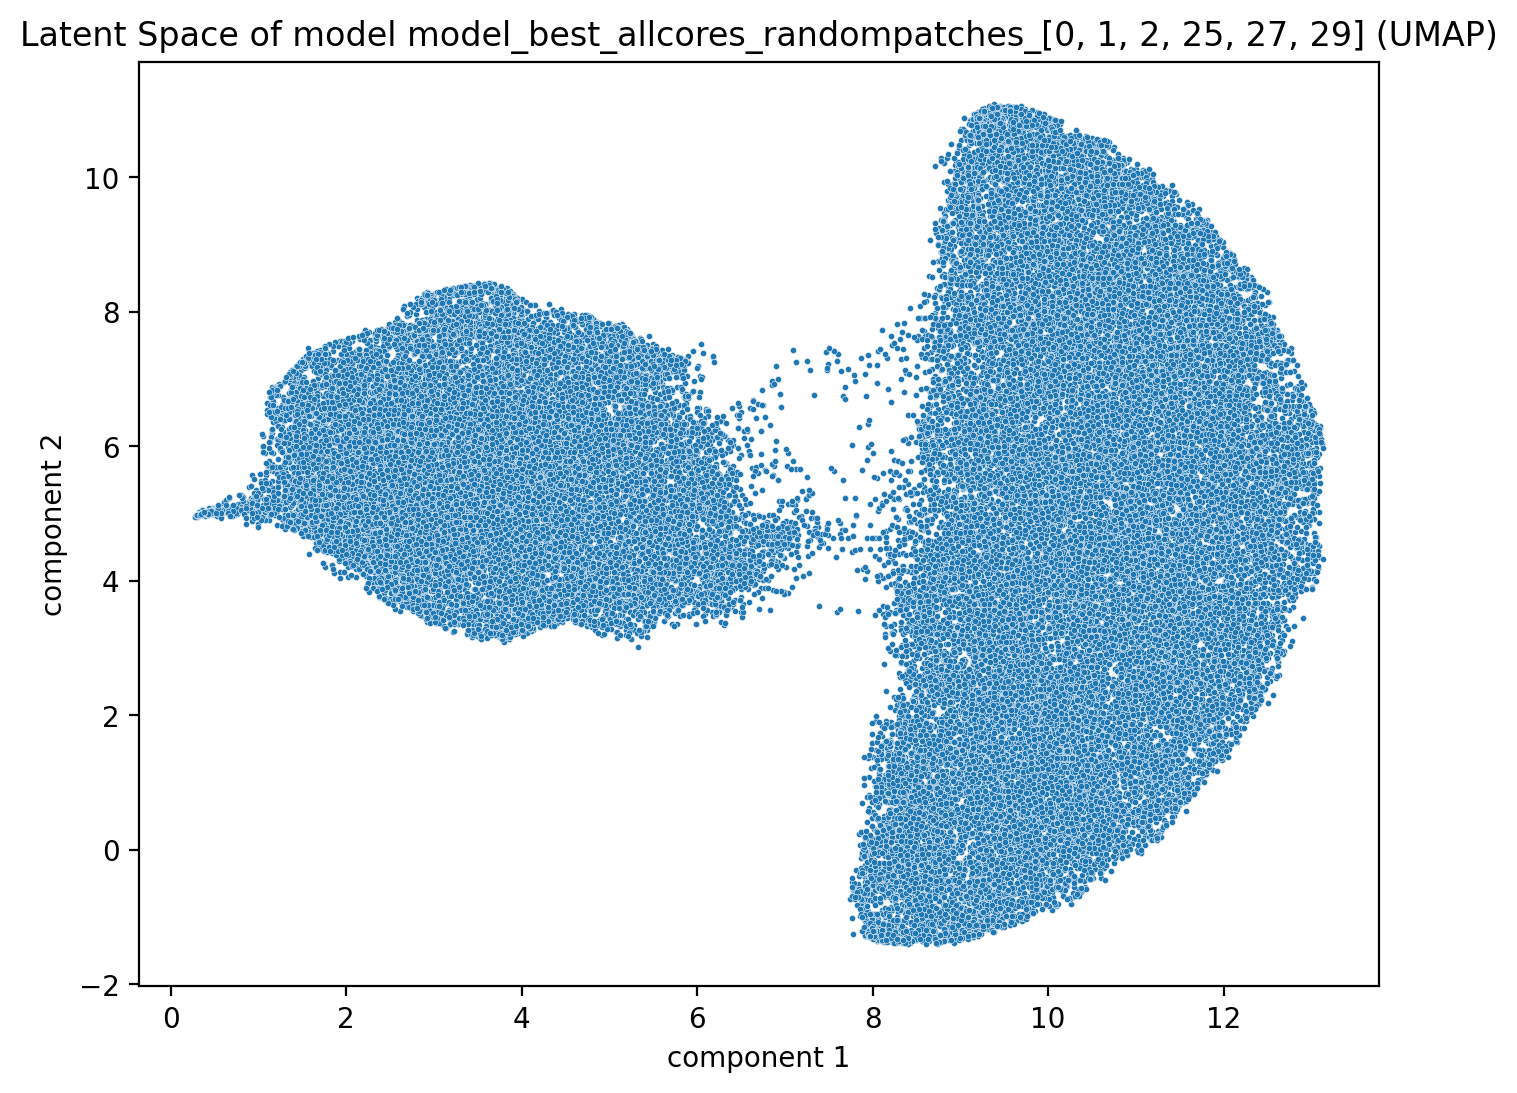

In [5]:
import umap.umap_ as umap

proj_2d = pd.DataFrame(
        data=umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean').fit_transform(all_value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(8, 6))
sns.scatterplot(data=proj_2d, x="component 1", y="component 2", alpha=1, s=5)
plt.title("Latent Space of model {} (UMAP)".format(model_name))
plt.show()

In [17]:
proj_2d_cluster1 = proj_2d.query('(`component 1` >= 8)').sample(n=10) # random select samples in each clusters
proj_2d_cluster2 = proj_2d.query('(`component 1` <= 6)').sample(n=10)
proj_2d_cluster3 = proj_2d.query('(`component 1` <= 7.5 & `component 1` >= 7)').sample(n=10)

In [18]:
patch_1 = []
for i in proj_2d_cluster1.index:
    patch_1.append(patches_files[i])

patch_2 = []
for i in proj_2d_cluster2.index:
    patch_2.append(patches_files[i])

patch_3 = []
for i in proj_2d_cluster3.index:
    patch_3.append(patches_files[i])

#### Plot origin patches in each clusters

Channel DAPI(0) median = 96.0, mean = 96.46209716796875, std = 25.416749135511242


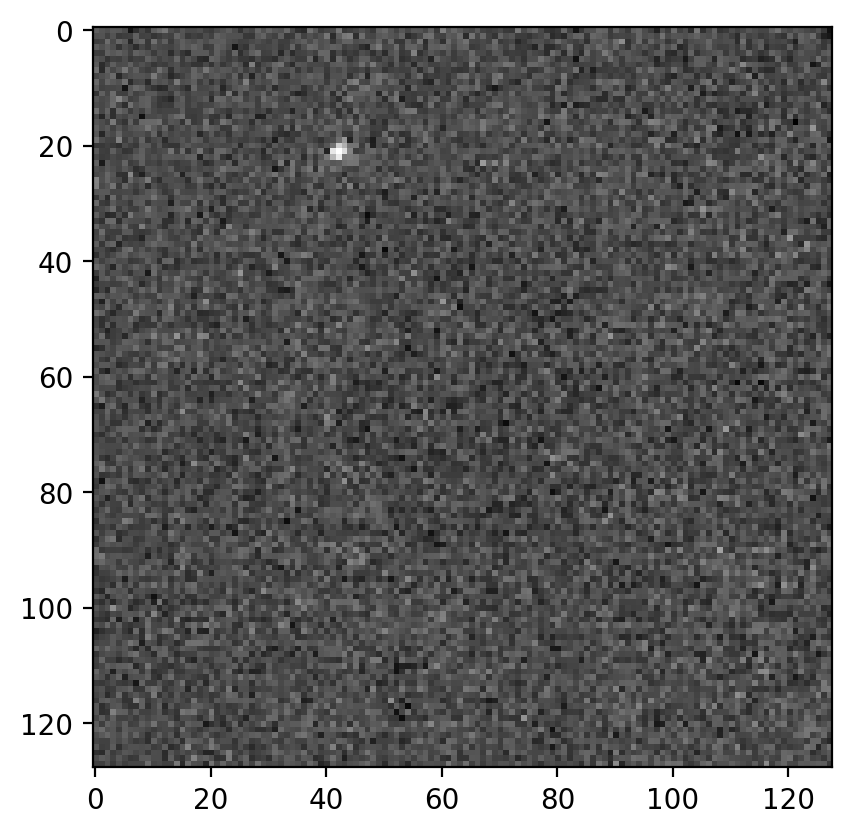

Channel DAPI(0) median = 121.0, mean = 121.91119384765625, std = 22.132661912444856


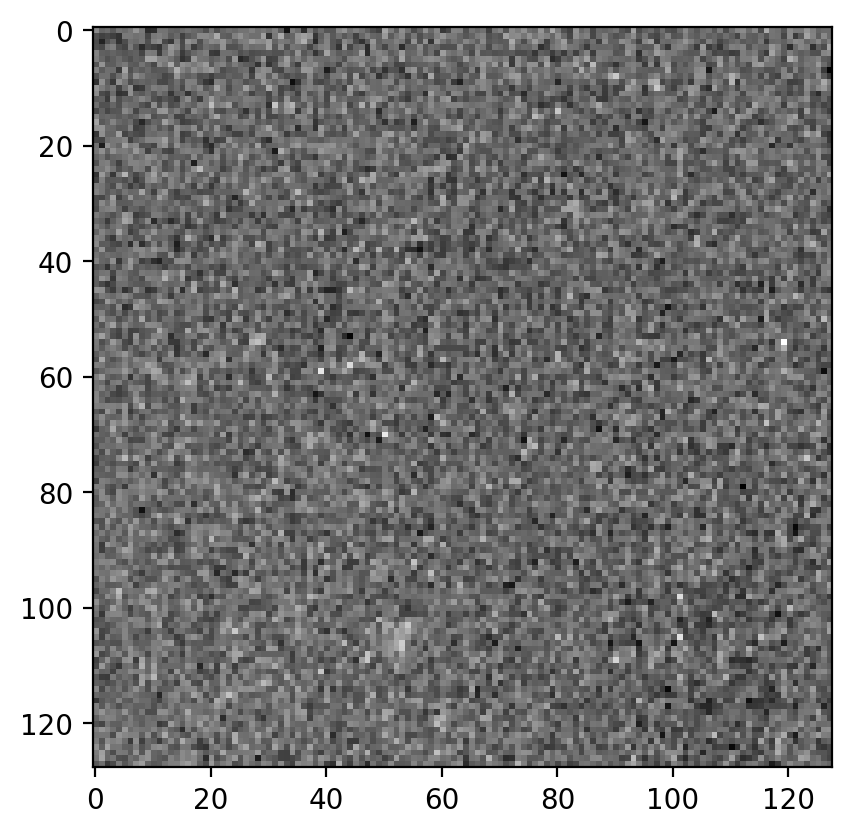

Channel DAPI(0) median = 338.0, mean = 338.0198974609375, std = 36.70649688626471


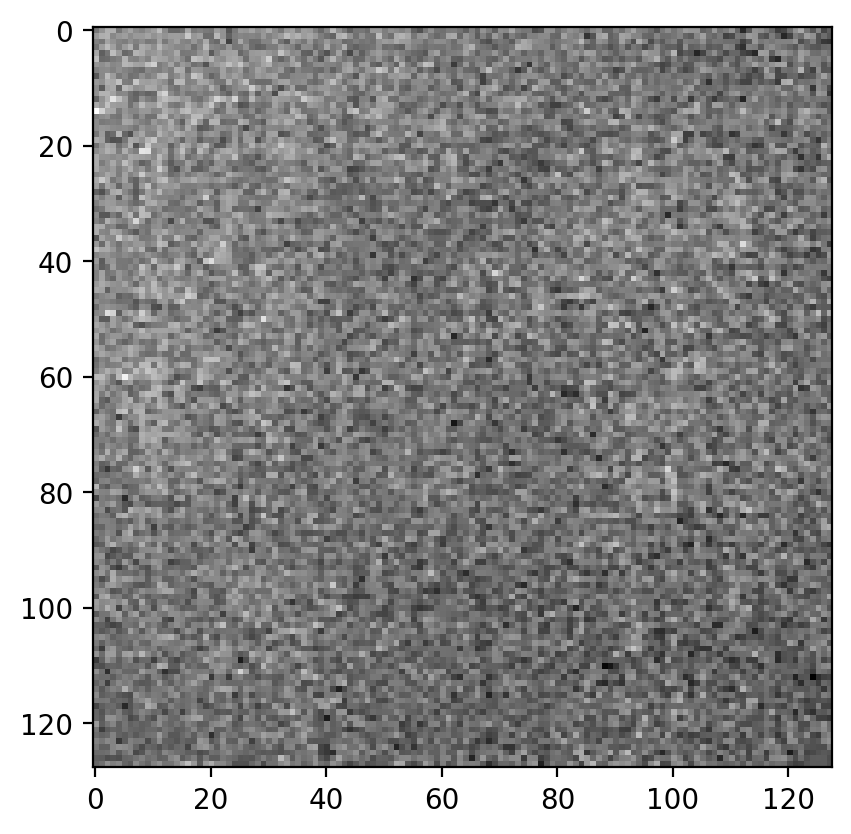

Channel DAPI(0) median = 166.0, mean = 167.67919921875, std = 40.21276412262886


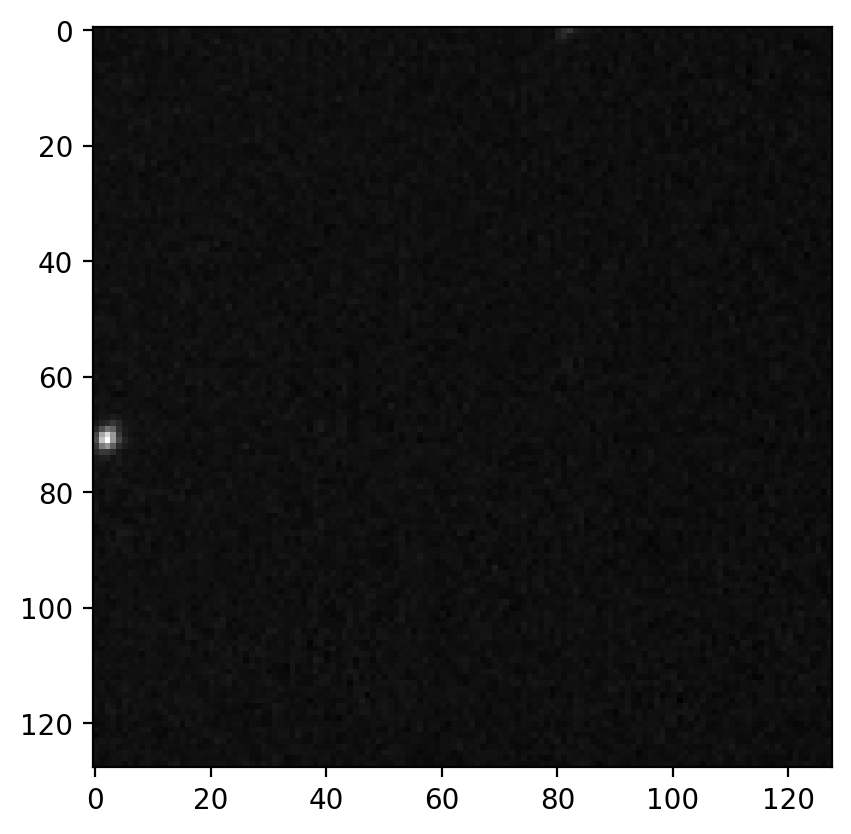

Channel DAPI(0) median = 93.0, mean = 92.7005615234375, std = 19.357491072507084


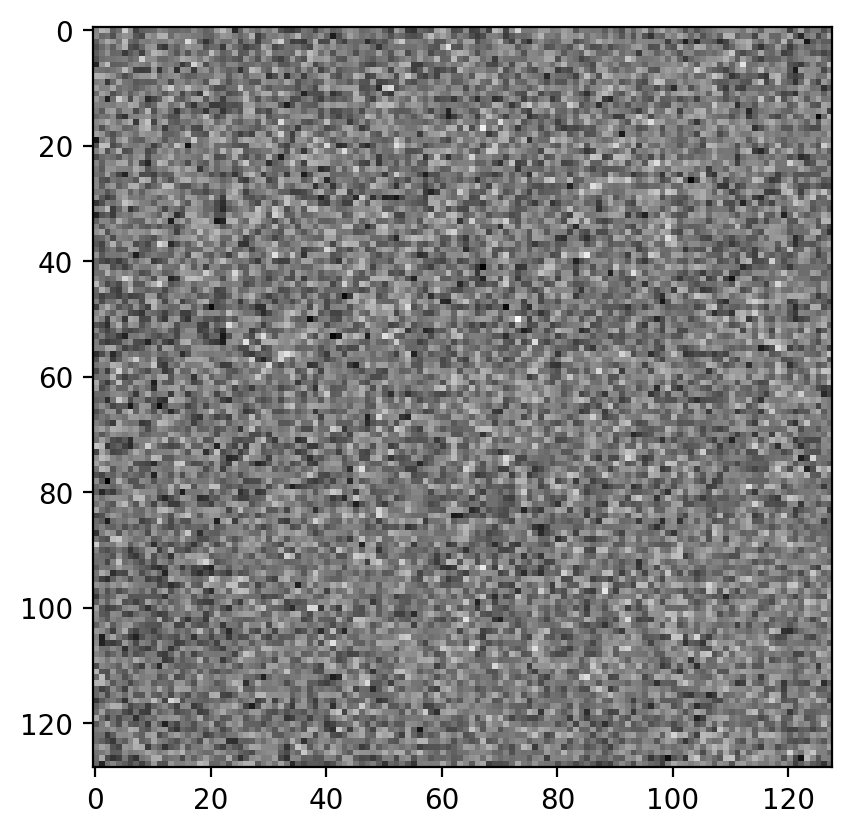

Channel DAPI(0) median = 174.0, mean = 660.0888671875, std = 2086.3026116940964


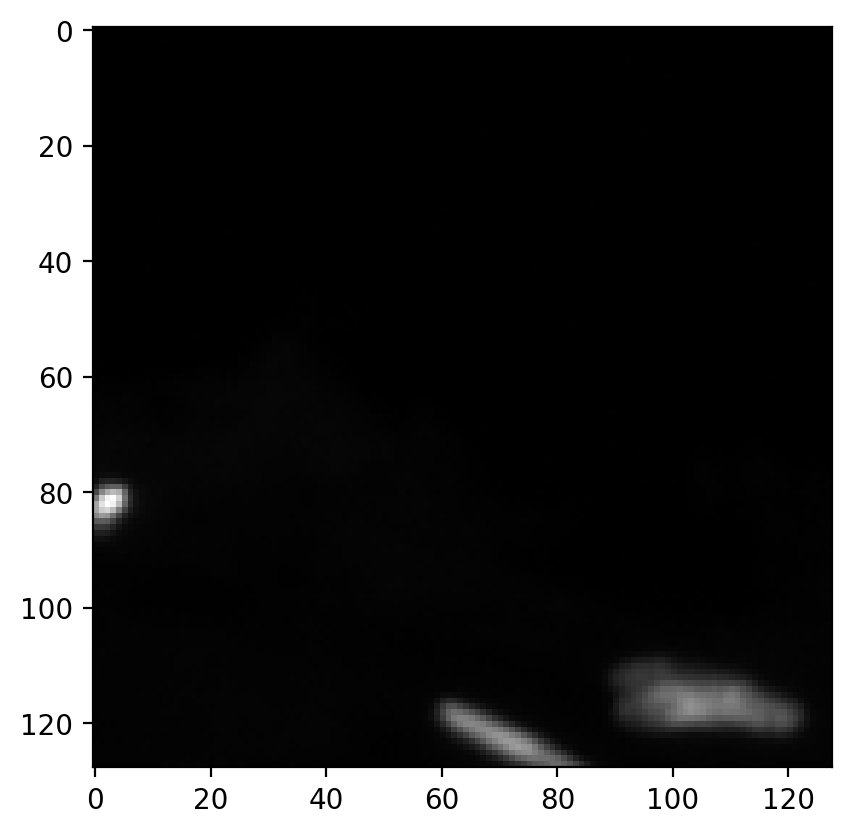

Channel DAPI(0) median = 109.0, mean = 109.4952392578125, std = 19.482757971978938


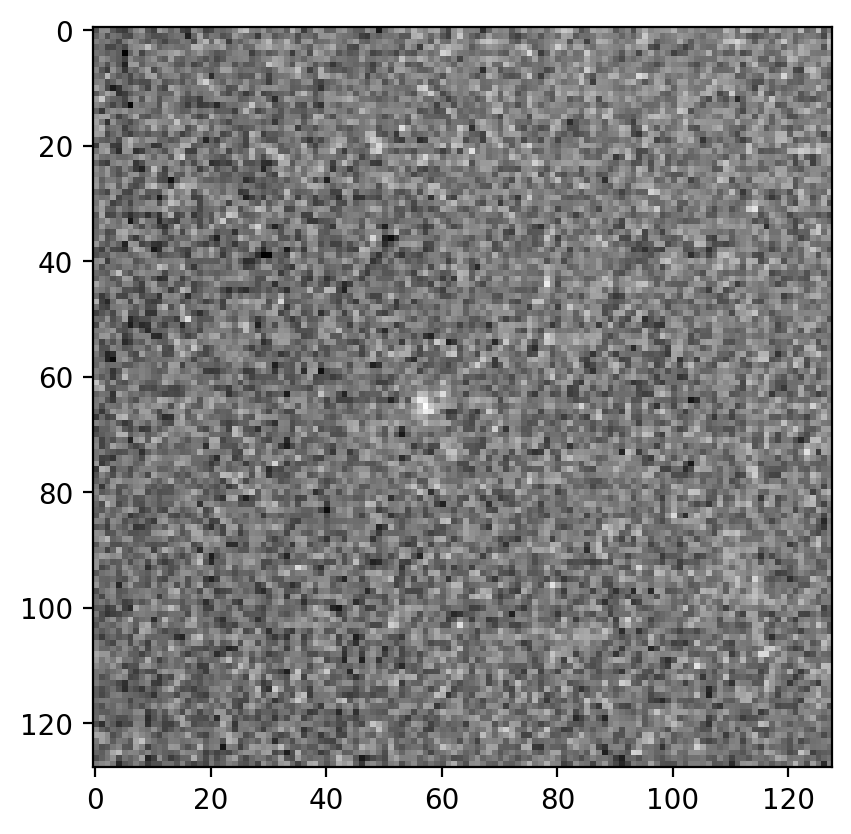

Channel DAPI(0) median = 190.0, mean = 190.60198974609375, std = 27.094670876180924


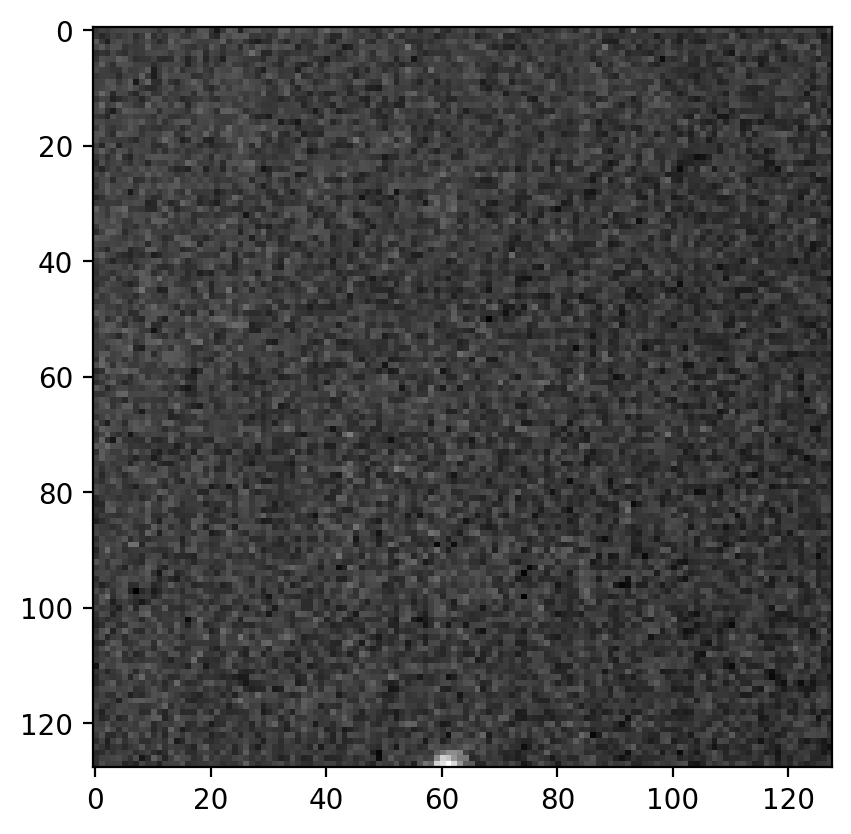

Channel DAPI(0) median = 211.0, mean = 211.99432373046875, std = 26.447760540434853


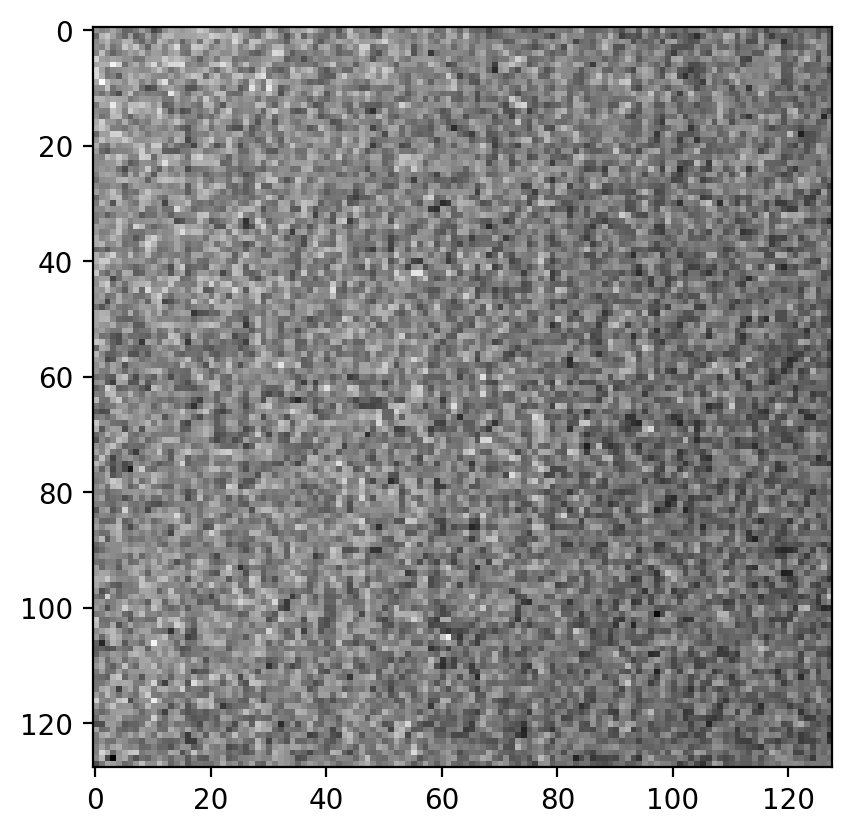

Channel DAPI(0) median = 164.0, mean = 166.58062744140625, std = 38.81869815390683


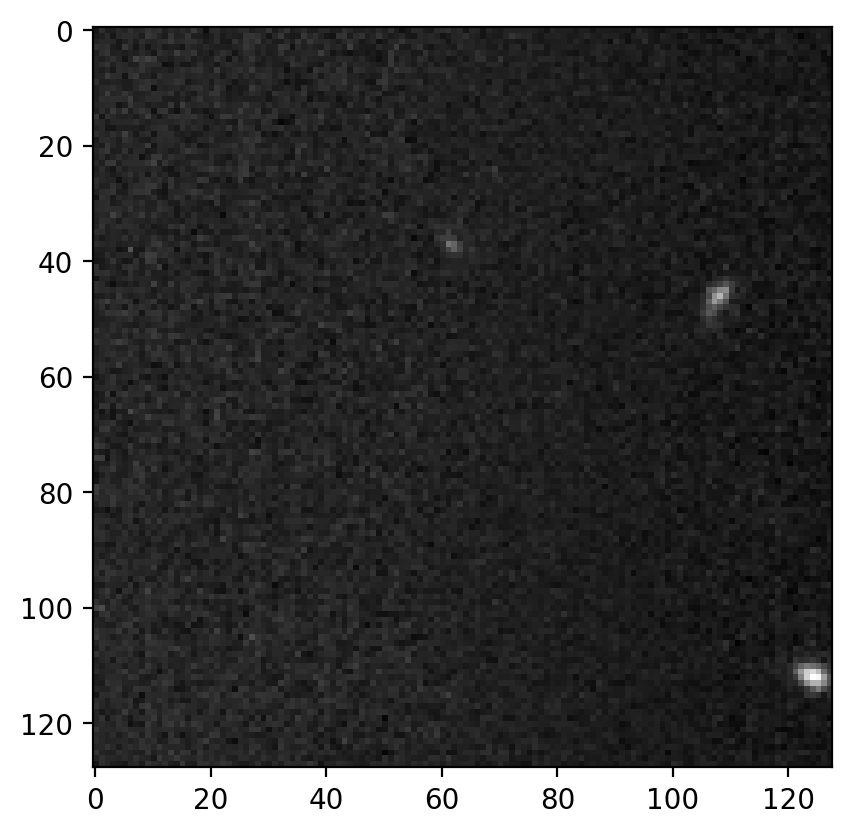

In [15]:
import tifffile

for i in range(10): 
    im_core_1_patch_0 = tifffile.imread(patch_1[i])
    im_core_1_patch_0[0,:,:]
    print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.std(im_core_1_patch_0[0,:,:].flatten())))
    plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
    plt.show()

Channel DAPI(0) median = 8724.0, mean = 12985.442993164062, std = 12316.474056313995


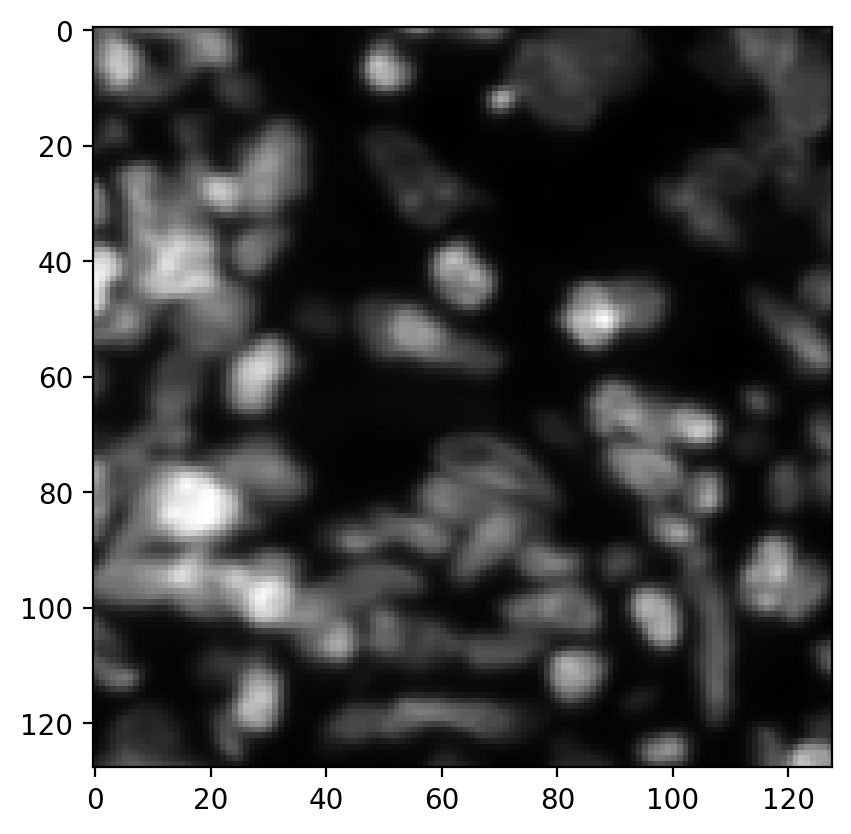

Channel DAPI(0) median = 338.5, mean = 1774.590576171875, std = 5154.813155151741


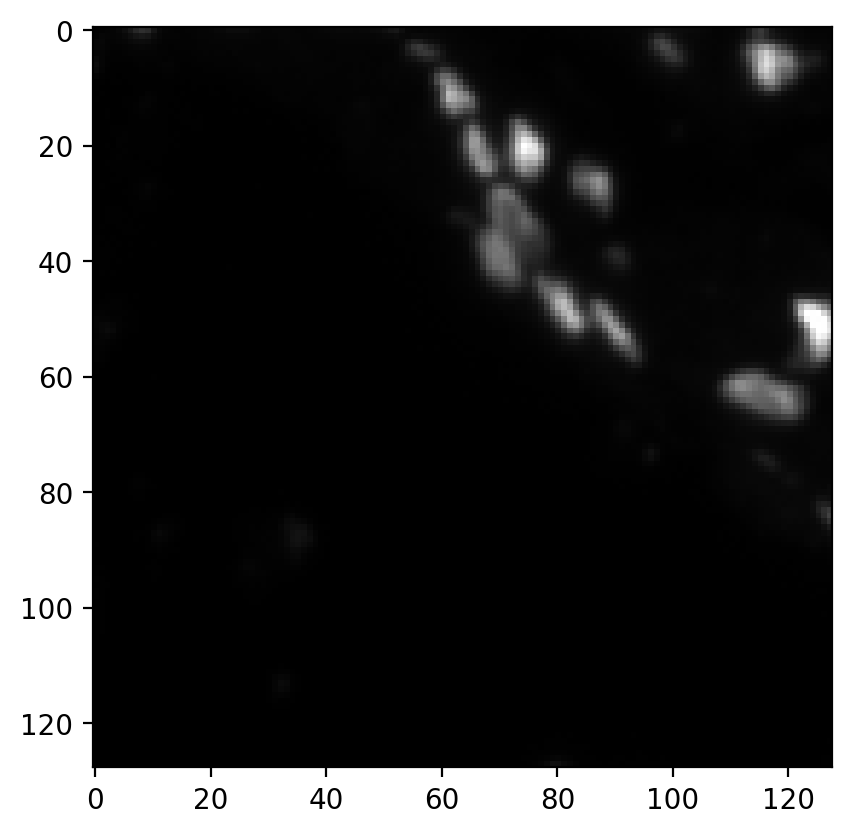

Channel DAPI(0) median = 1490.5, mean = 6079.347900390625, std = 9188.92594457206


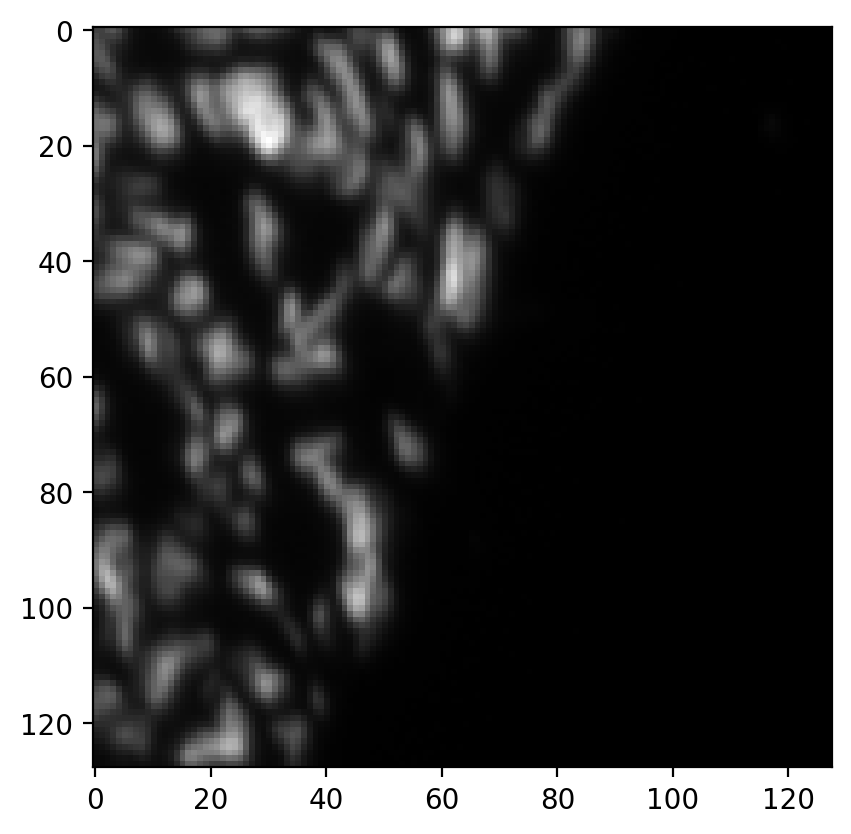

Channel DAPI(0) median = 27369.5, mean = 27932.26904296875, std = 14831.222974692691


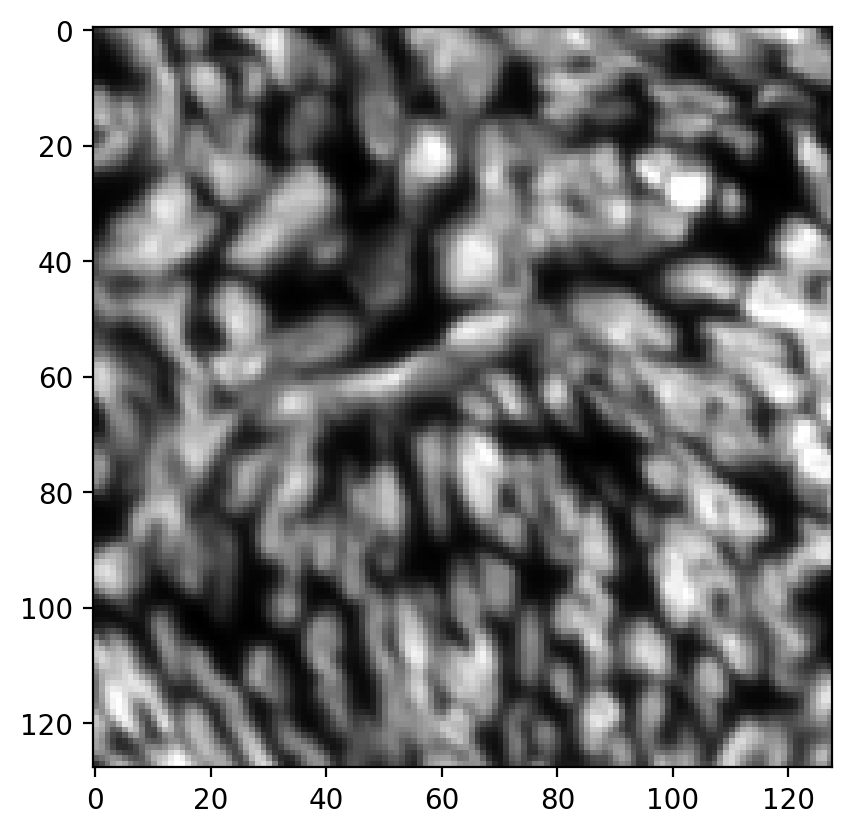

Channel DAPI(0) median = 2265.5, mean = 5008.176025390625, std = 7539.063778522975


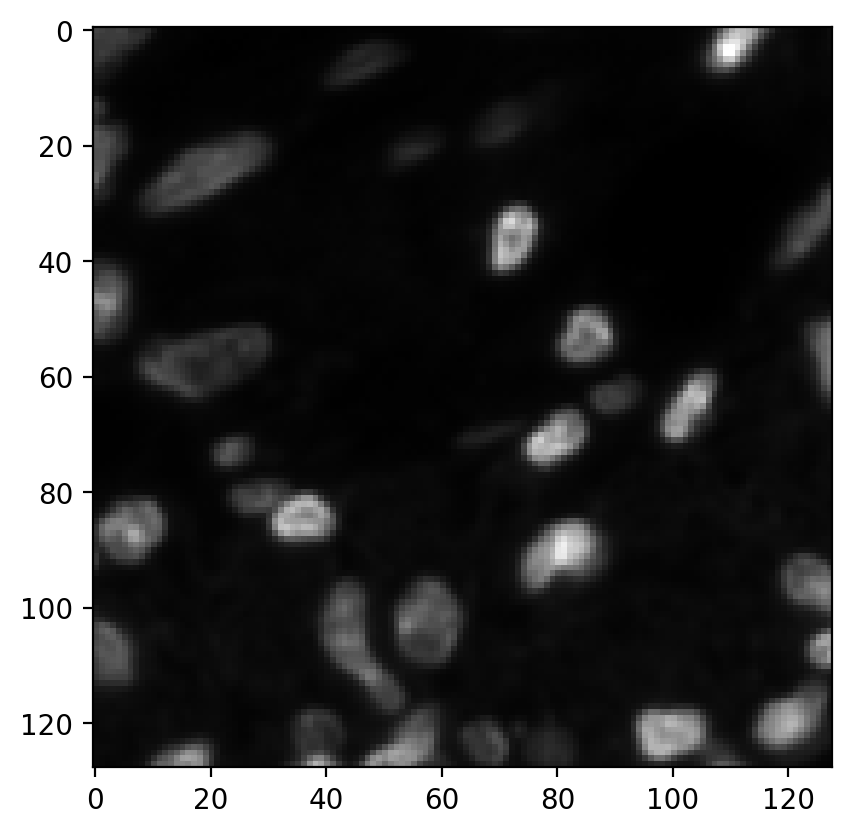

Channel DAPI(0) median = 1360.0, mean = 2101.1258544921875, std = 3725.852746241496


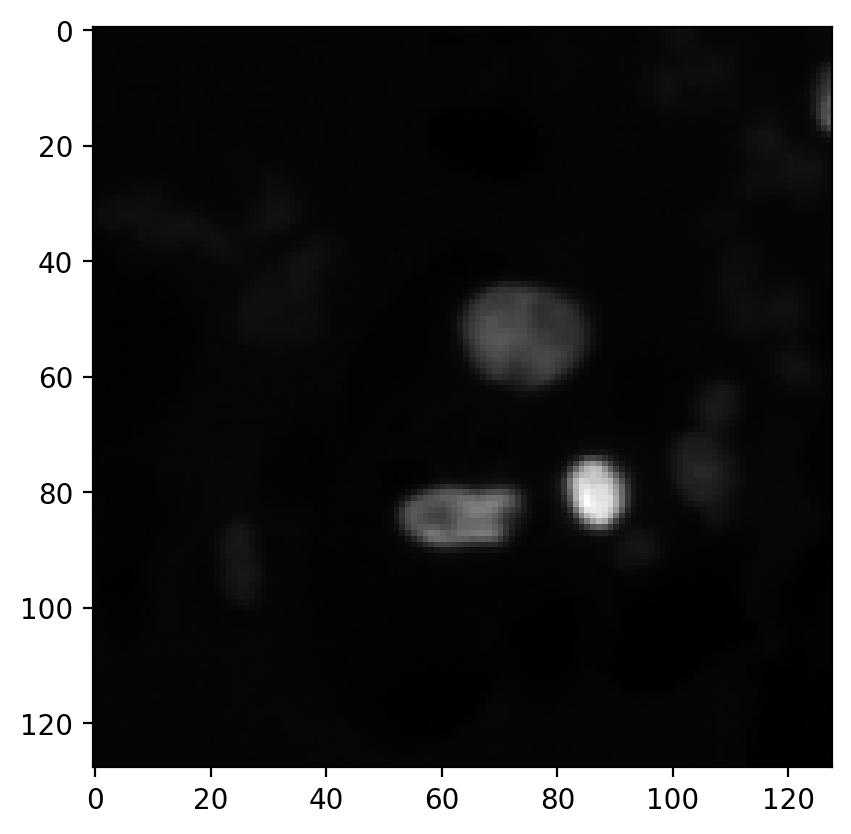

Channel DAPI(0) median = 7024.0, mean = 13667.524047851562, std = 15171.940593709836


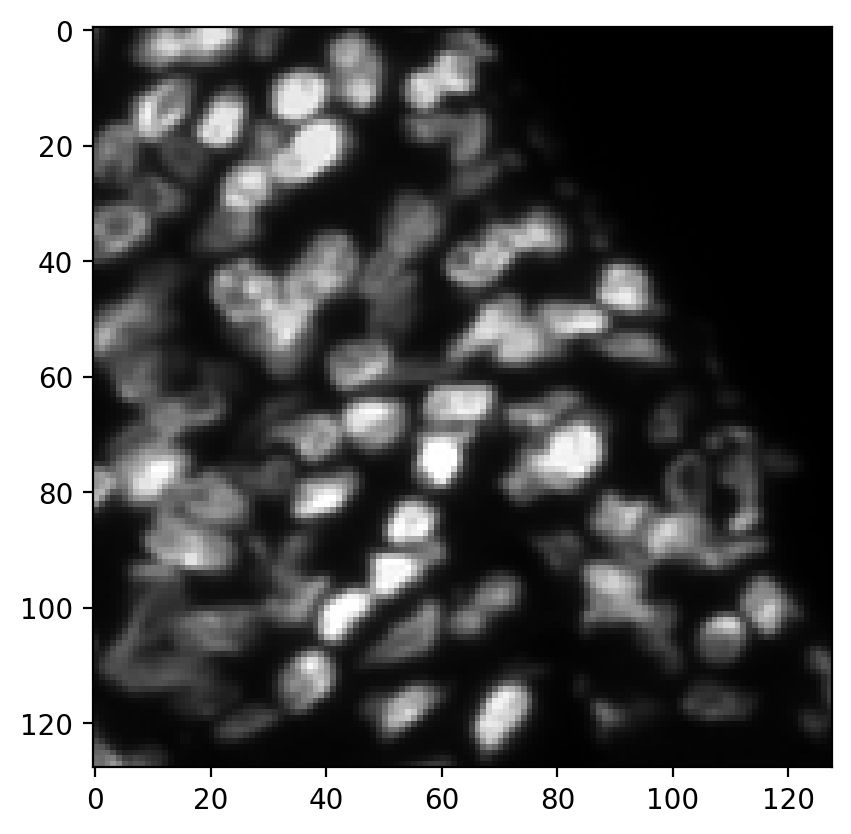

Channel DAPI(0) median = 2097.5, mean = 7250.430236816406, std = 9932.419053731424


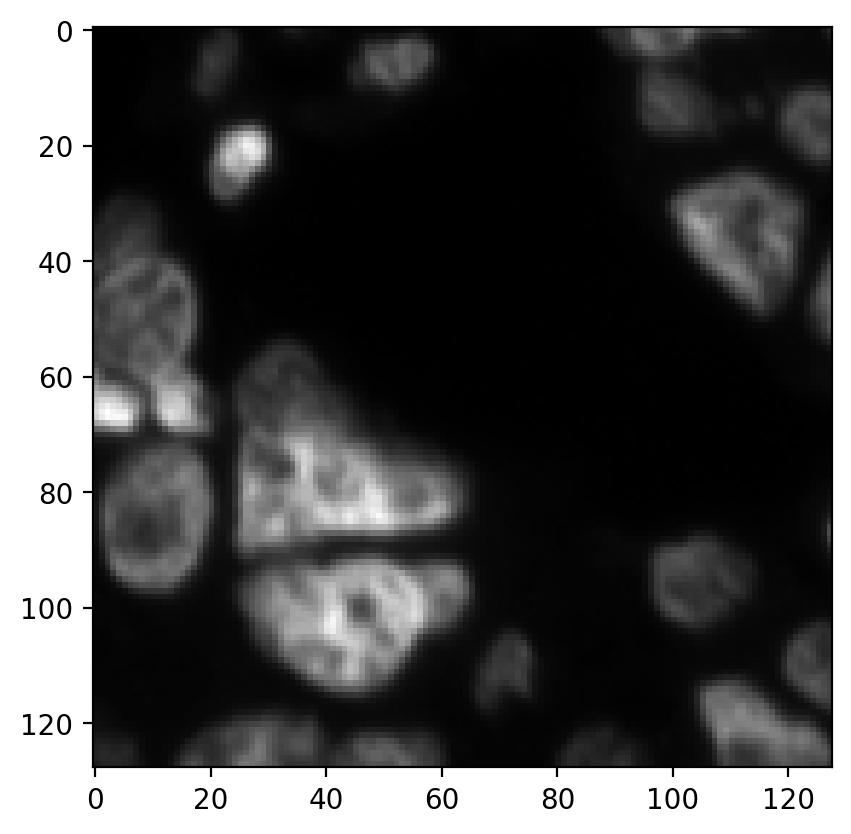

Channel DAPI(0) median = 273.0, mean = 600.5701293945312, std = 1789.5609075714747


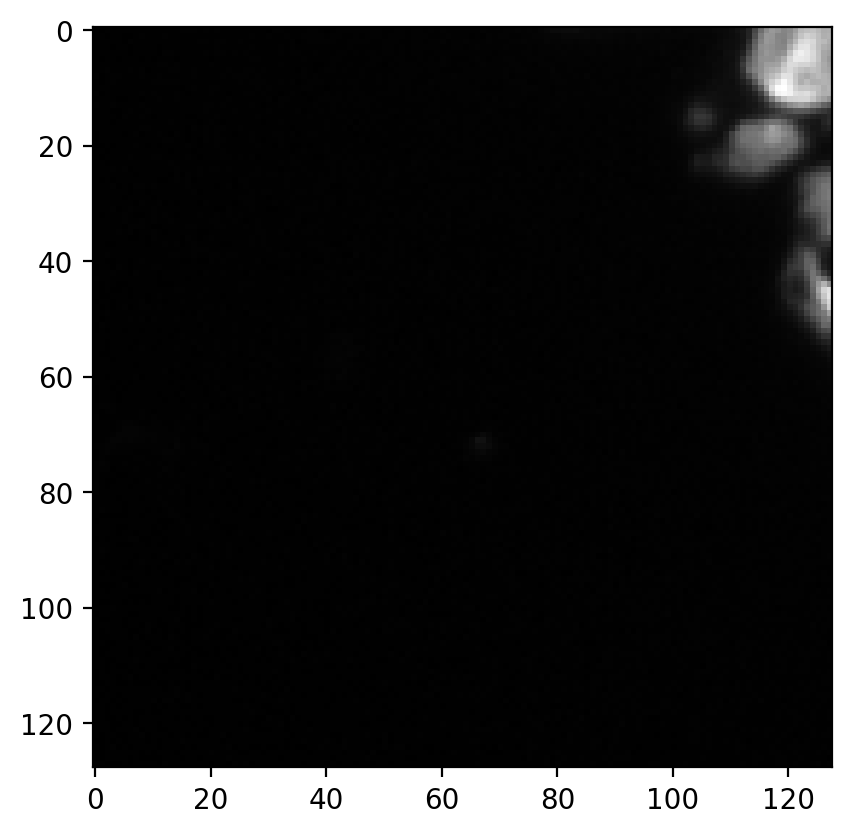

Channel DAPI(0) median = 1001.5, mean = 3409.7800903320312, std = 6096.909249911134


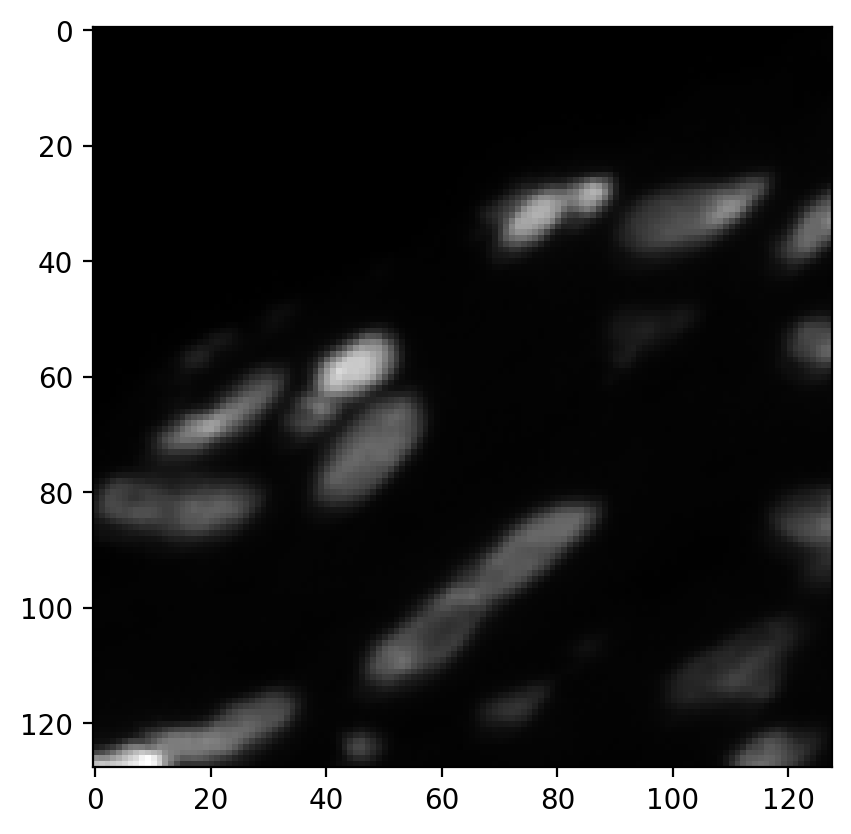

In [16]:
for i in range(10): 
    im_core_1_patch_0 = tifffile.imread(patch_2[i])
    im_core_1_patch_0[0,:,:]
    print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.std(im_core_1_patch_0[0,:,:].flatten())))
    plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
    plt.show()

Channel DAPI(0) median = 317.0, mean = 887.3966064453125, std = 2473.009238218228


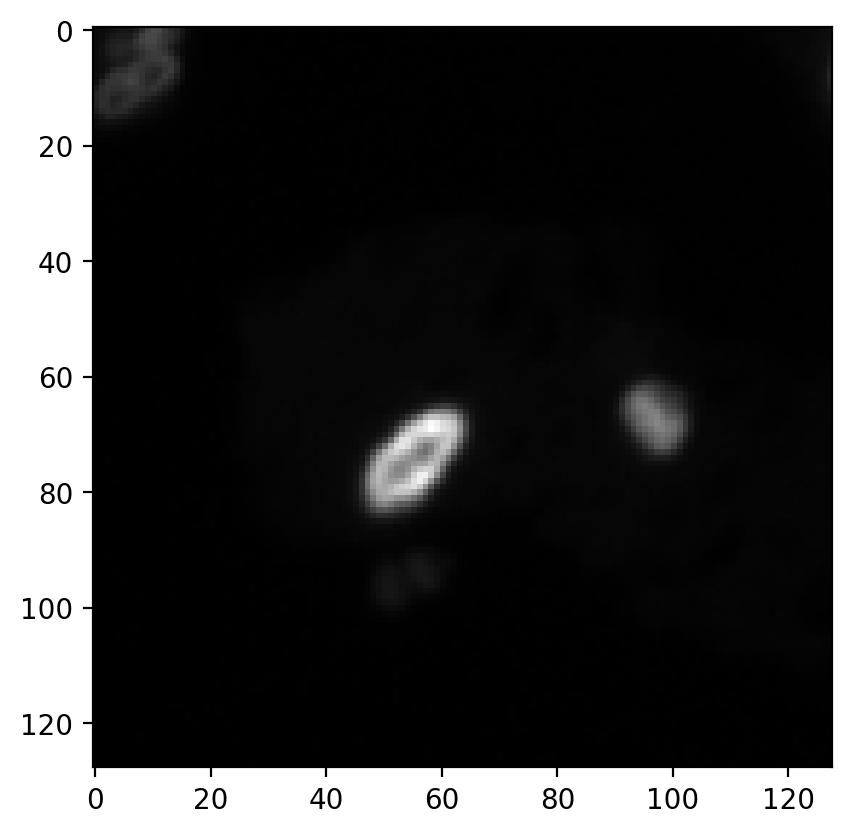

Channel DAPI(0) median = 1866.0, mean = 5832.243408203125, std = 7601.143022700168


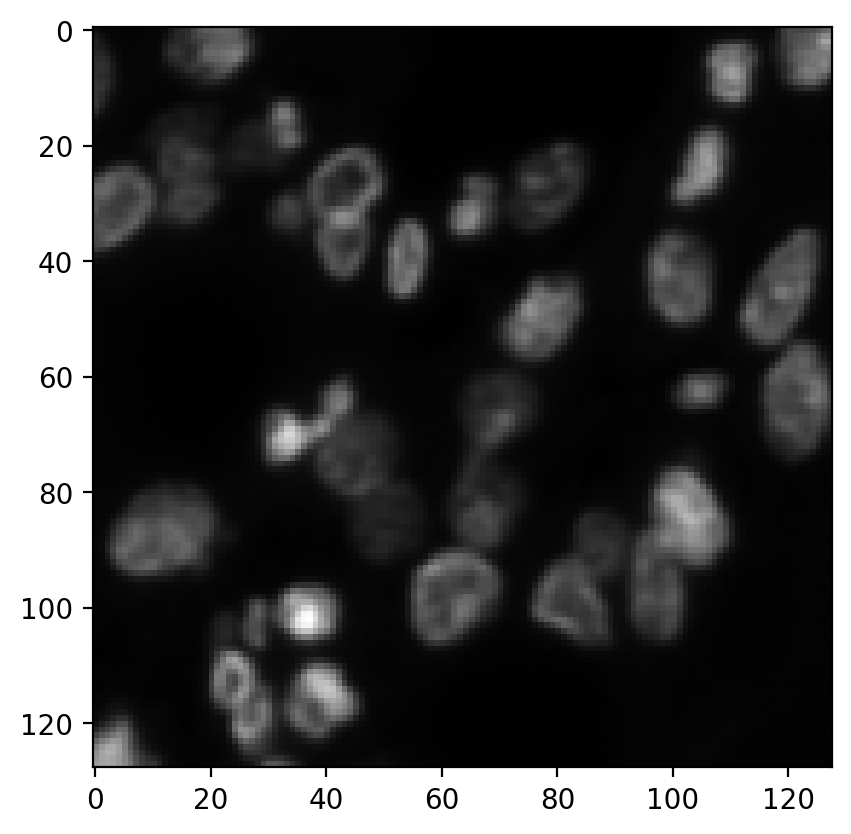

Channel DAPI(0) median = 3239.5, mean = 6715.54150390625, std = 7376.607453402469


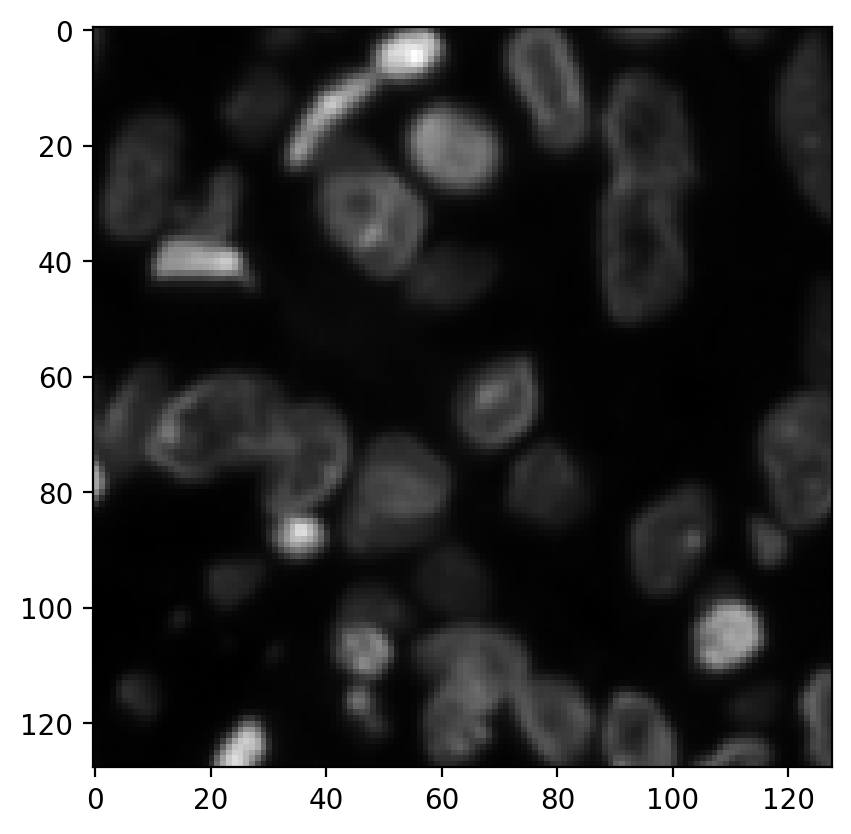

Channel DAPI(0) median = 274.0, mean = 1108.1153564453125, std = 2803.070595185792


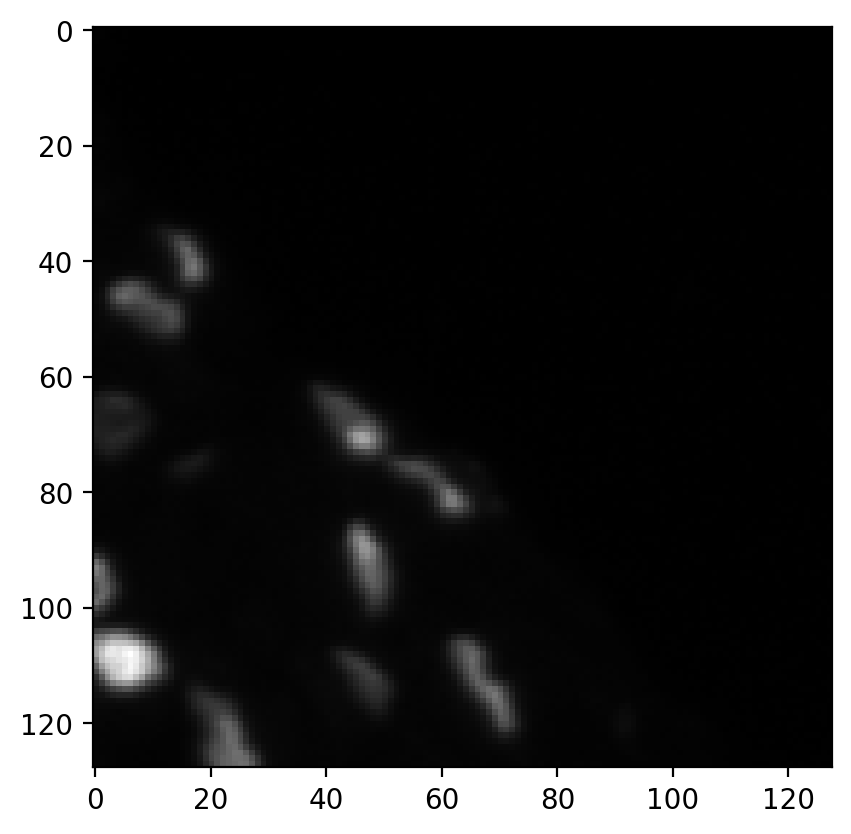

Channel DAPI(0) median = 8047.5, mean = 12195.323974609375, std = 10593.509670647907


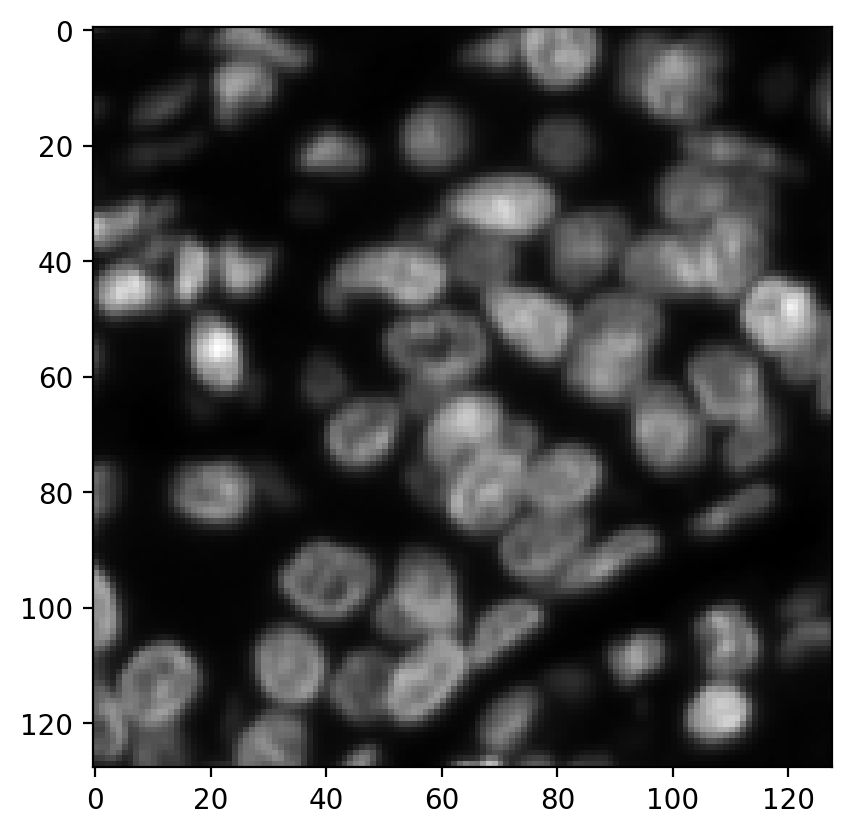

Channel DAPI(0) median = 1096.0, mean = 2189.447021484375, std = 4578.663795166753


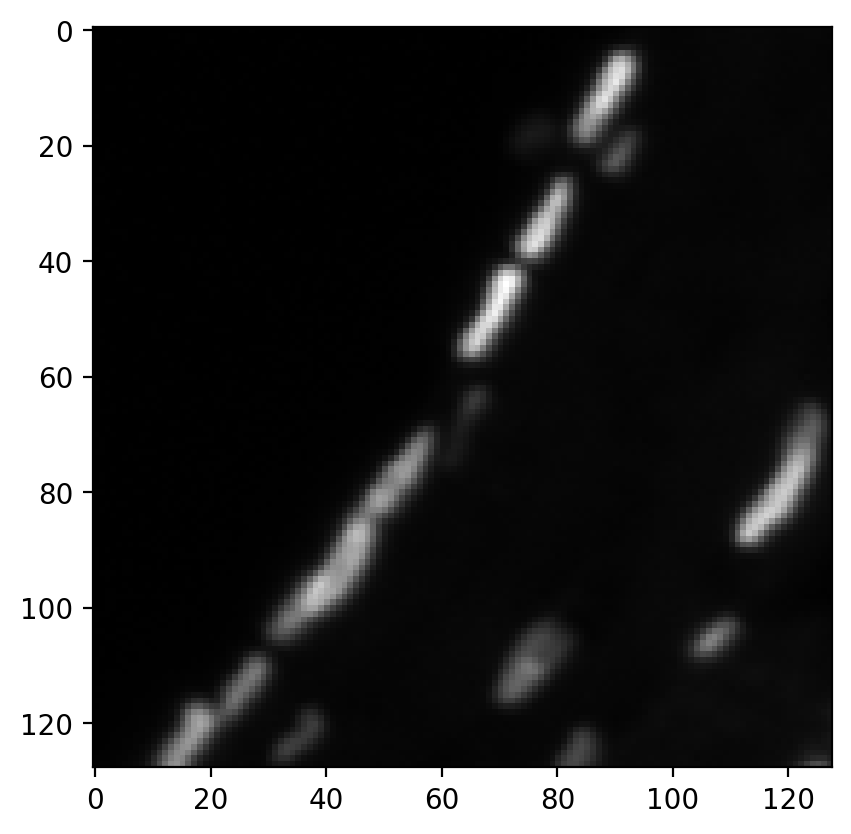

Channel DAPI(0) median = 548.0, mean = 763.015869140625, std = 2851.381586575676


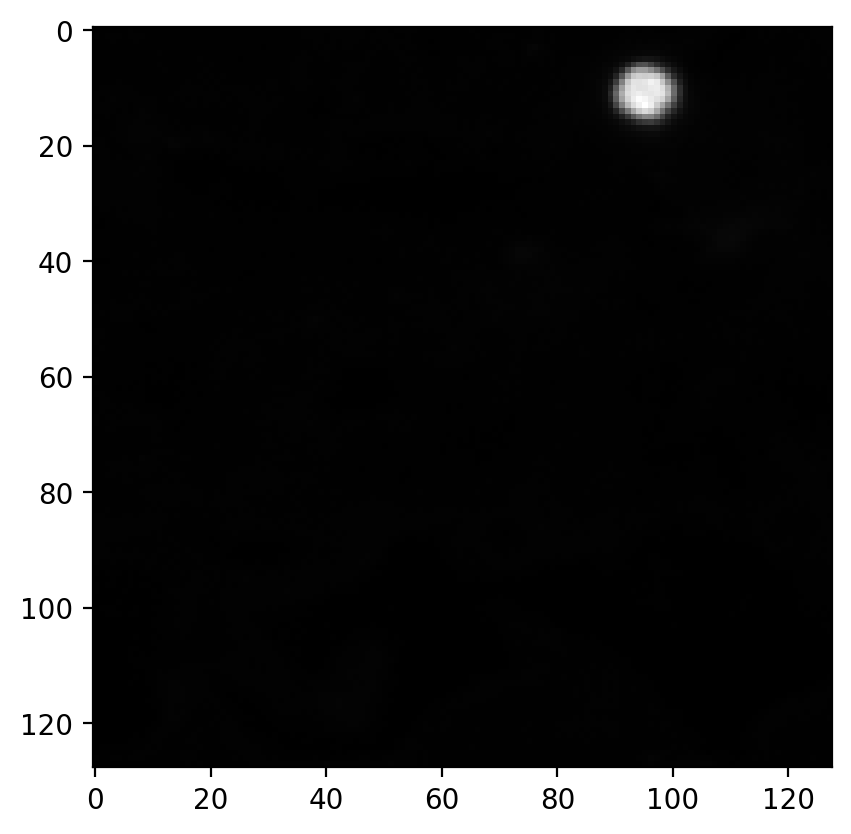

Channel DAPI(0) median = 810.0, mean = 822.0443725585938, std = 162.32838984217094


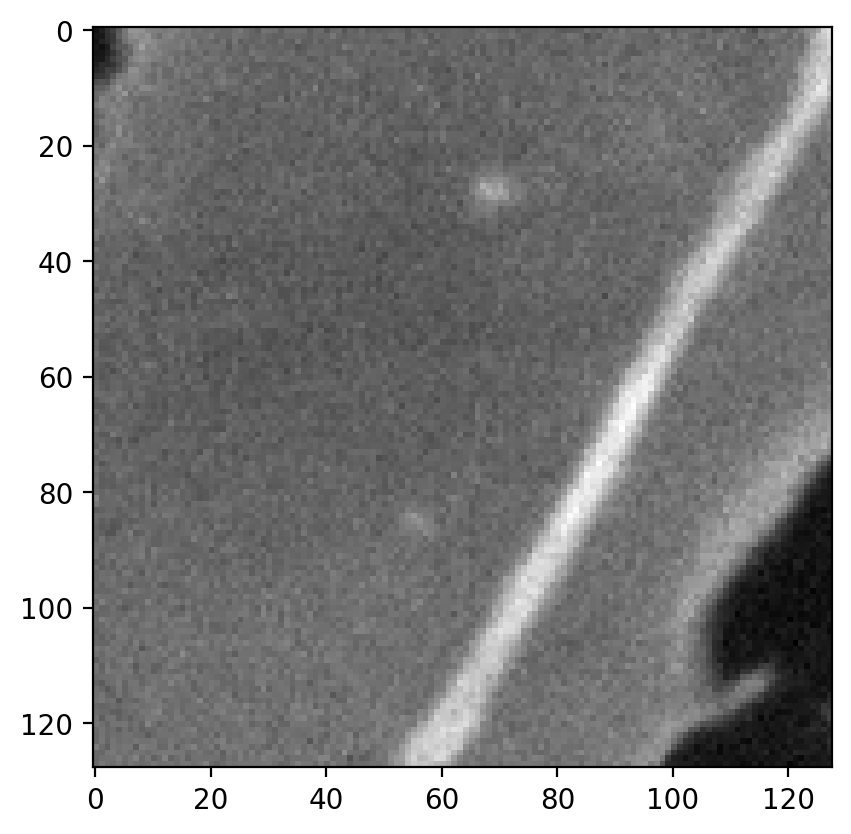

Channel DAPI(0) median = 4466.0, mean = 7835.103576660156, std = 7866.012087214399


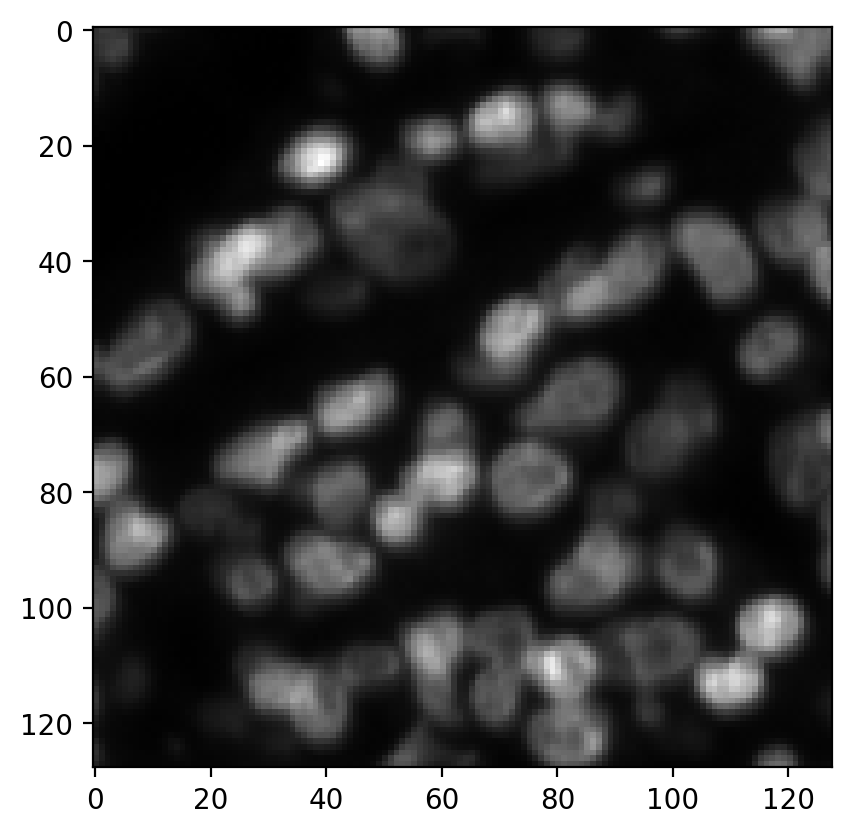

Channel DAPI(0) median = 340.0, mean = 982.1145629882812, std = 3526.1992265366084


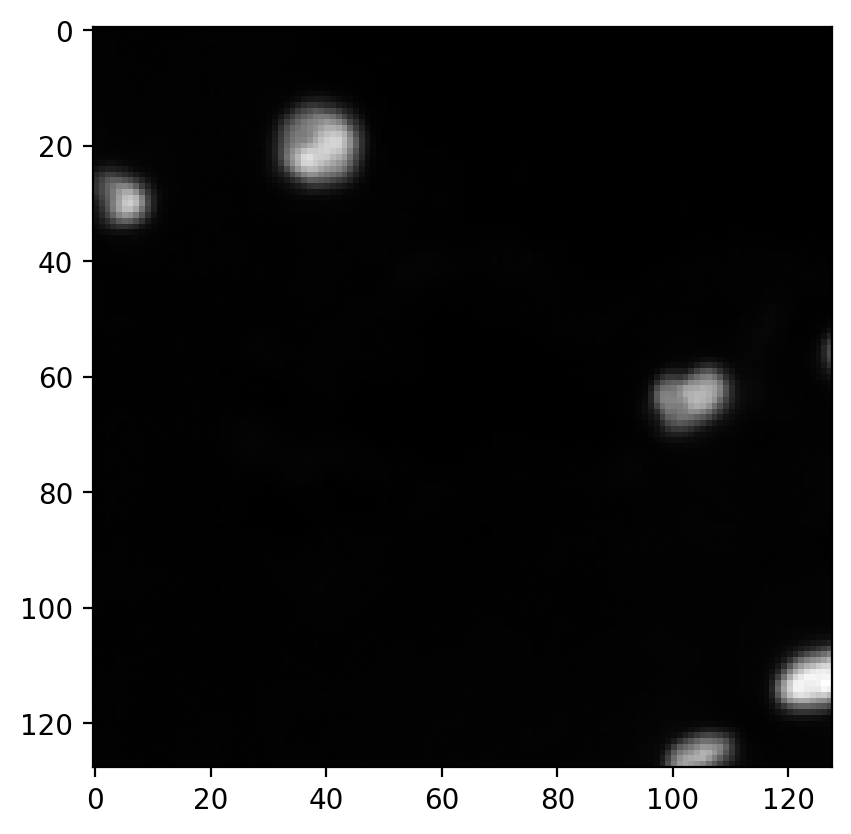

In [19]:
for i in range(10): 
    im_core_1_patch_0 = tifffile.imread(patch_3[i])
    im_core_1_patch_0[0,:,:]
    print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.std(im_core_1_patch_0[0,:,:].flatten())))
    plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
    plt.show()

### TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 53959 samples in 0.078s...
[t-SNE] Computed neighbors for 53959 samples in 16.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 53959
[t-SNE] Computed conditional probabilities for sample 2000 / 53959
[t-SNE] Computed conditional probabilities for sample 3000 / 53959
[t-SNE] Computed conditional probabilities for sample 4000 / 53959
[t-SNE] Computed conditional probabilities for sample 5000 / 53959
[t-SNE] Computed conditional probabilities for sample 6000 / 53959
[t-SNE] Computed conditional probabilities for sample 7000 / 53959
[t-SNE] Computed conditional probabilities for sample 8000 / 53959
[t-SNE] Computed conditional probabilities for sample 9000 / 53959
[t-SNE] Computed conditional probabilities for sample 10000 / 53959
[t-SNE] Computed conditional probabilities for sample 11000 / 53959
[t-SNE] Computed conditional probabilities for sample 12000 / 53959
[t-SNE] Computed conditional probabilities for s

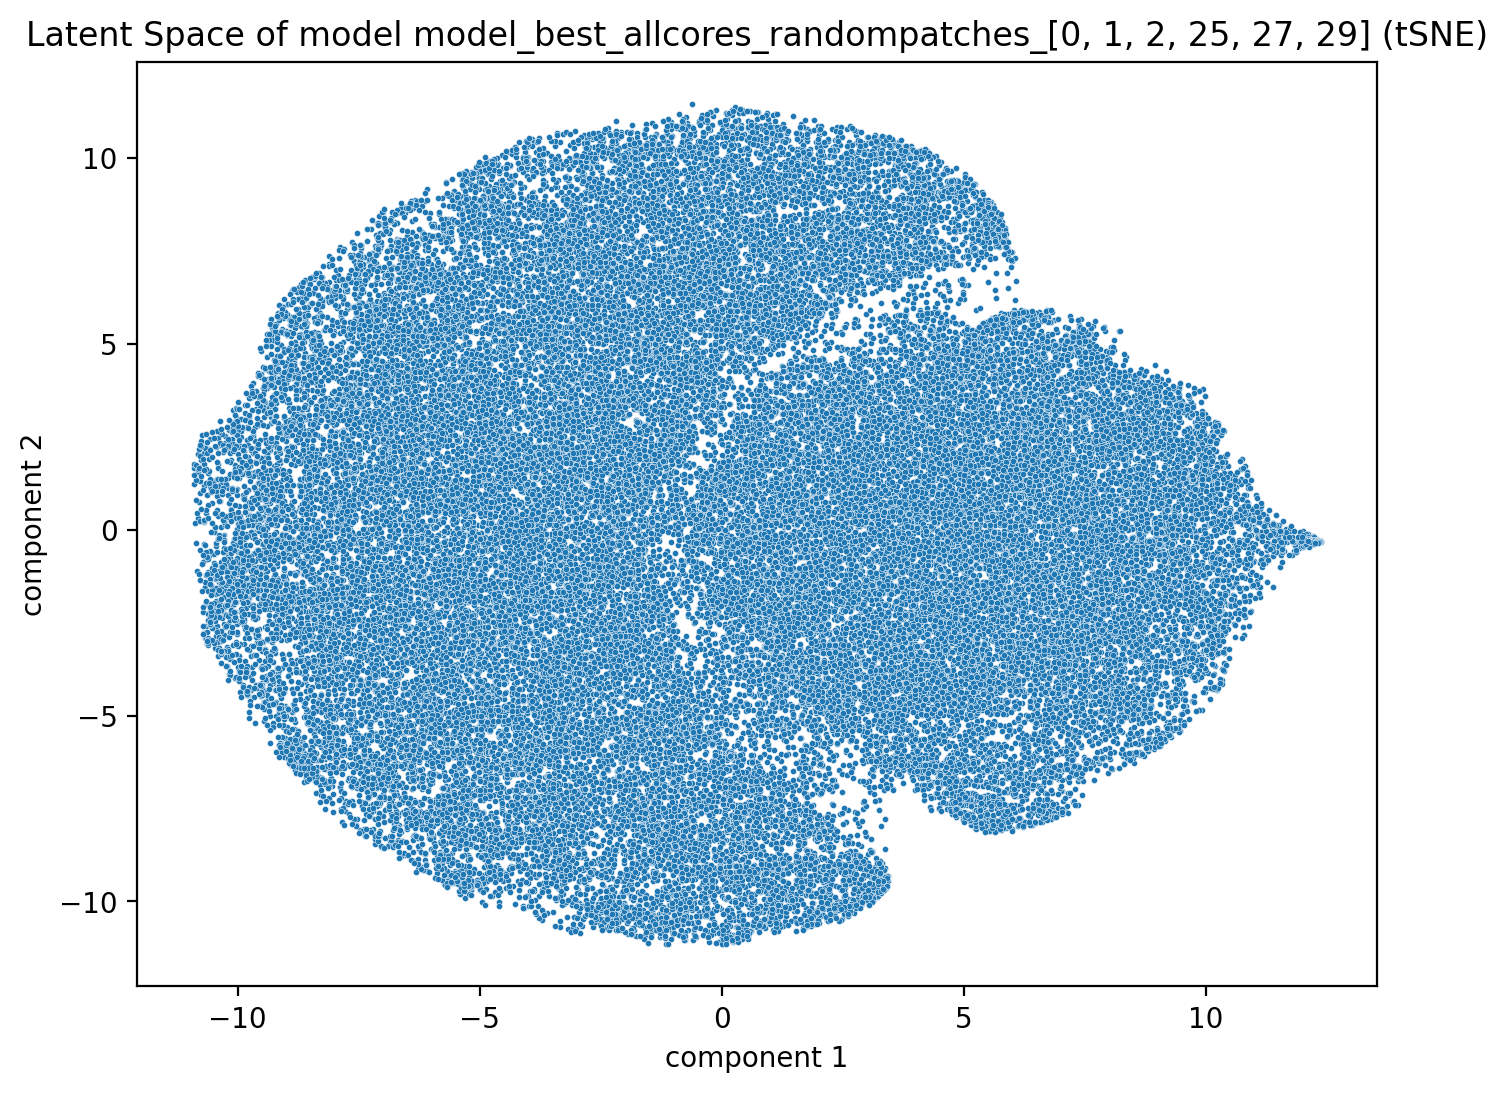

In [12]:
proj_2d_tsne = pd.DataFrame(
        data=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(all_value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(8, 6))
sns.scatterplot(data=proj_2d_tsne, x="component 1", y="component 2", alpha=1, s=5)
plt.title("Latent Space of model {} (tSNE)".format(model_name))
plt.show()